In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


In [3]:
train_dir = '/content/drive/MyDrive/brain tumour dataset/Training'
test_dir = '/content/drive/MyDrive/brain tumour dataset/Testing'

img_height, img_width = 224, 224
batch_size = 32


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [5]:
vgg_base = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
vgg_base.trainable = False

model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
import glob

checkpoint_dir = '/content/drive/MyDrive/vgg16_checkpoints'

# Find all checkpoint weight files saved with .weights.h5 extension
weights_files = glob.glob(checkpoint_dir + '/cp-*.weights.h5')

latest_checkpoint = None
initial_epoch = 0

if weights_files:
    # Sort files by epoch number extracted from filename
    def extract_epoch(f):
        import re
        match = re.search(r'cp-(\d+).weights.h5', f)
        return int(match.group(1)) if match else -1
    weights_files.sort(key=extract_epoch)
    latest_checkpoint = weights_files[-1]

if latest_checkpoint:
    print(f"Loading weights from {latest_checkpoint}")
    model.load_weights(latest_checkpoint)
    initial_epoch = extract_epoch(latest_checkpoint)
    print(f"Resuming from epoch {initial_epoch}")
else:
    print("No checkpoint found, starting training from scratch")



Loading weights from /content/drive/MyDrive/vgg16_checkpoints/cp-0020.weights.h5
Resuming from epoch 20


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:04d}.weights.h5")
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_freq='epoch'
)

In [8]:
history = model.fit(
    train_gen,
    epochs=20,
    initial_epoch=initial_epoch,
    validation_data=val_gen,
    callbacks=[checkpoint_cb]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [9]:
final_model_path = '/content/drive/MyDrive/vgg16_brain_tumor_classifier.h5'
model.save(final_model_path)
print(f"Model saved at: {final_model_path}")


Model saved at: /content/drive/MyDrive/vgg16_brain_tumor_classifier.h5


Saving meningioma.jpg to meningioma.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step


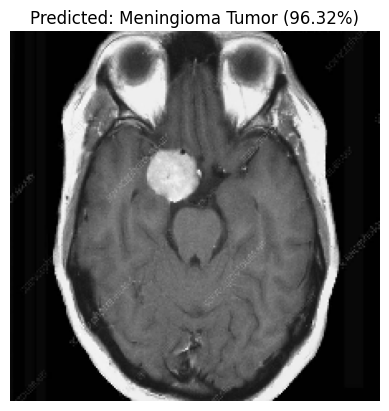

Predicted class: Meningioma Tumor
Confidence: 96.32%


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files

# Load trained model
model_path = '/content/drive/MyDrive/vgg16_brain_tumor_classifier.h5'   # Update path if needed
model = tf.keras.models.load_model(model_path)

# Class labels (change as per your dataset/class order)
class_labels = ['Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']

# Upload MRI image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
predictions = model.predict(img_array)
pred_idx = np.argmax(predictions[0])
pred_label = class_labels[pred_idx]
confidence = np.max(predictions[0]) * 100

# Display image and result
plt.imshow(img)
plt.title(f'Predicted: {pred_label} ({confidence:.2f}%)')
plt.axis('off')
plt.show()

print(f'Predicted class: {pred_label}')
print(f'Confidence: {confidence:.2f}%')
